In [285]:
import argparse
import os
import sys
import time
import numpy as np
from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import urllib
import time

from einops import repeat, rearrange

This is following the model from LucidRains with some advisement from the original code

https://github.com/lucidrains/ESBN-pytorch

# helper functions

In [3]:
def exists(val):
    return val is not None

In [4]:
def safe_cat(t, el, dim =0):
    if not exists(t):
        return el
    return tf.concat((t, el), axis = dim)

In [5]:
def map_fn(fn, *args, **kwargs):
    def inner(*arr):
        return map(lambda t: fn(t, *args, **kwargs), arr)
    return inner

# the Class

In [437]:
class ESBN(keras.layers.Layer):
    def __init__(
        self,
        *,
        value_dim = 64,
        key_dim = 64,
        hidden_dim = 512,
        output_dim = 4,
        encoder = None
    ):
        super().__init__()
        self.output_dim = output_dim
        self.h0 = tf.zeros(hidden_dim)
        self.c0 = tf.zeros(hidden_dim)
        self.k0 = tf.zeros(key_dim + 1)
        
        # self.h0 = tf.random.uniform([hidden_dim])
        # self.c0 = tf.random.uniform([hidden_dim])
        # self.k0 = tf.random.uniform([key_dim + 1])
        
        self.rnn = tf.keras.layers.LSTMCell(hidden_dim)  #What is the difference between this and just LSTM
        self.to_gate = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) #?
        self.to_key = tf.keras.layers.Dense(key_dim)
        self.to_output = tf.keras.layers.Dense(output_dim)
        
        self.encoder = tf.keras.Sequential()
        self.encoder.add(tf.keras.layers.Reshape((32, 32, 1))) #to deal with shape issue
        self.encoder.add(tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, 
                                                activation=tf.keras.activations.relu))
        self.encoder.add(tf.keras.layers.Conv2D(64, kernel_size=4, strides=2,
                                                activation=tf.keras.activations.relu))
        self.encoder.add(tf.keras.layers.Conv2D(64, kernel_size=4, strides=2,
                                                activation=tf.keras.activations.relu))
        self.encoder.add(tf.keras.layers.Flatten())
        self.encoder.add(tf.keras.layers.Dense(value_dim))
                         # if not exists(encoder) else encoder What does???
            
        self.to_confidence = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
        
    def call(self, images):
        #return images
        print('images shape: ', images.shape)
        b = images.shape[1] #what exactly is this
        print('b shape ', b)
        Mk = tf.zeros((tf.shape(images)[0], 0, 64))
        Mv = tf.zeros((tf.shape(images)[0], 0, 64))
        # Mk = tf.random.uniform((tf.shape(images)[0], 0, 64))
        # Mv = tf.random.uniform((tf.shape(images)[0], 0, 64))
        
        
        #hx, cx, kx, k0 = map_fn(repeat, 'd -> b d', b = b)(self.h0, self.c0, self.k0, self.k0)
        hx = tf.zeros((tf.shape(images)[0], 1, self.h0.shape[-1]))
        cx = tf.zeros((tf.shape(images)[0], 1, self.c0.shape[-1]))
        kx = tf.zeros((tf.shape(images)[0], 1, self.k0.shape[-1]))
        k0 = tf.zeros((tf.shape(images)[0], 1, self.k0.shape[-1]))
        out = tf.TensorArray(dtype=tf.float32,
                             size=tf.shape(images)[0],
                             dynamic_size=True)
        
        #ind = tf.Variable(0, trainable=False, dtype=tf.int32)
        ind = tf.constant(0)

        #for ind, image in enumerate(images):
        def body(ind, out):
            nonlocal Mk, Mv, hx, cx, kx, k0, b
            #nonlocal images
            
            image = images[:,ind,:,:]
            print('in loop single shape:',image.shape)
            is_first = ind == 0
            z = self.encoder(image)
            print('z : ', z.shape)
            print('kx ', kx)
            print('hx : ', hx.shape)
            print('cx : ', cx)
            hx, cx = self.rnn(kx, (hx, cx)) #return state?
            
            y, g, kw = self.to_output(hx), self.to_gate(hx), self.to_key(hx)
            
            # if is_first: #redundent?
            #     kx = k0
            # else:
            if not is_first:
                # attention
                sim = tf.einsum('b n d, b d -> b n', Mv, z)
                # wk = tf.keras.layers.Activation(activation=tf.keras.activations.softmax)(sim)
                wk = tf.nn.softmax(sim)
                
                # calculate confidence
                sim, wk = map_fn(rearrange, 'b n -> b n ()')(sim, wk) #consider
                ck = self.to_confidence(sim)
                
                #kx = g.sigmoid() * (wk * torch.cat((Mk, ck), dim = -1)).sum(dim = 1)
                cc = tf.keras.layers.concatenate([Mk, ck], axis=-1) #verified to work the same
                cc = tf.math.reduce_sum(wk * cc, axis = 1) #same as torch.sum
                kx = g * cc
                
            kw, z = map_fn(rearrange, 'b d -> b () d')(kw, z)
            Mk = safe_cat(Mk, kw, dim = 1)
            Mv = safe_cat(Mv, z, dim = 1)

            out.write(ind, y)
                
            #ind.assign_add(1) #incriment i
            return [ind + 1, out]
                
        
        
        tf.while_loop(
            lambda i,ind: i < tf.shape(images)[1] + 1,
            body, 
            [ind, out])

        return out.stack() 
                

# Same-Difference

In [497]:
#This is all part of the args mess in their code
#initially setting this to be theri defaults

#Model Settings
model_name = 'ESBN'
norm_type = 'contextnorm'
encoder = 'conv'
#Task settings
task = 'same_diff'
train_gen_mathod = 'full_space'
n_shapes = 100 #total num of shapes available for training/testing
m_holdout = 0 #number of objects (out of n) withheld during training
#Training Settings
train_batch_size = 32
train_set_size = 10000
train_proportion = 0.95
lr = 5e-4
epochs = 50
log_interval = 10
#Test settings
test_batch_size = 100
test_set_size = 10000
#Device Settings
no_cuda = False #Actions??? 'store_true'
device = 0 
#run number
run = 1

In [498]:
all_shapes = np.arange(n_shapes)
np.random.shuffle(all_shapes)
all_shapes.shape

(100,)

In [499]:
if(m_holdout > 0):
    train_shapes = all_shapes[m_holdout:]
    test_shapes = all_shapes[:m_holdout]
else:
    train_shapes = all_shapes
    test_shapes = all_shapes
    
train_shapes.shape

(100,)

In [500]:
#now we're in their function
import sys
import random
import numpy as np

# Prevent python from saving out .pyc files
sys.dont_write_bytecode = True

y_dim = 2
seq_len = 2

In [501]:
# If m = 0, training and test sets are drawn from same set of shapes
if(m_holdout == 0):
    # Total number of possible trials
    shapes_avail = n_shapes
    total_trials = (shapes_avail * (shapes_avail - 1)) * 2
    
    # Proportion of training set size vs test set size
    test_proportion = 1 - train_proportion
    
    # Create training/test set sizes
    train_set_size = np.round(train_proportion * total_trials).astype(np.int32)
    test_set_size = np.round(test_proportion * total_trials).astype(np.int32)
    
else: 
    # Ensure that there are enough potential trials for desired training set size 
    # (or change train set size)
    shapes_avail = n_shapes - m_holdout
    total_trials = (shapes_avail * (shapes_avail - 1)) * 2
    
    if(train_set_size > total_trials):
        train_set_size = total_trials
    
    # Ensure that there are enough potential trials for desired test set size 
    # (or change test set size)
    shapes_avail = n_shapes - (n_shapes - m_holdout)
    total_trials = (shapes_avail * (shapes_avail - 1)) * 2
    
    if(test_set_size > total_trials):
        test_set_size = total_trials

train_set_size

18810

In [502]:
# If m = 0, training and test sets are drawn from same set of shapes
if m_holdout == 0:
    # Create all possible trials
    same_trials = []
    diff_trials = []
    for shape1 in train_shapes:
        for shape2 in train_shapes:
            if shape1 == shape2:
                same_trials.append([shape1, shape2])
            else:
                diff_trials.append([shape1, shape2])
    # Shuffle
    random.shuffle(same_trials)
    random.shuffle(diff_trials)
    # Split trials for train and test sets
    same_trials_train = same_trials[:np.round(train_proportion * len(same_trials)).astype(np.int32)]
    same_trials_test = same_trials[np.round(train_proportion * len(same_trials)).astype(np.int32):]
    diff_trials_train = diff_trials[:np.round(train_proportion * len(diff_trials)).astype(np.int32)]
    diff_trials_test = diff_trials[np.round(train_proportion * len(diff_trials)).astype(np.int32):]
# Otherwise, training and test sets are completely disjoint (in terms of the shapes that are used), and can be generated separately
else:
    # Create all possible training trials
    same_trials_train = []
    diff_trials_train = []
    for shape1 in train_shapes:
        for shape2 in train_shapes:
            if shape1 == shape2:
                same_trials_train.append([shape1, shape2])
            else:
                diff_trials_train.append([shape1, shape2])
    # Shuffle
    random.shuffle(same_trials_train)
    random.shuffle(diff_trials_train)
    # Create all possible test trials
    same_trials_test = []
    diff_trials_test = []
    for shape1 in test_shapes:
        for shape2 in test_shapes:
            if shape1 == shape2:
                same_trials_test.append([shape1, shape2])
            else:
                diff_trials_test.append([shape1, shape2])
    # Shuffle
    random.shuffle(same_trials_test)
    random.shuffle(diff_trials_test)

In [503]:
# Duplicate 'same' trials to match number of 'different' trials
same_trials_train_balanced = []
for t in range(len(diff_trials_train)):
    same_trials_train_balanced.append(same_trials_train[np.floor(np.random.rand()*len(same_trials_train)).astype(np.int32)])
same_trials_test_balanced = []
for t in range(len(diff_trials_test)):
    same_trials_test_balanced.append(same_trials_test[np.floor(np.random.rand()*len(same_trials_test)).astype(np.int32)])
# Combine all same and different trials for training set
all_train_seq = []
all_train_targ = []
for t in range(len(same_trials_train_balanced)):
    all_train_seq.append(same_trials_train_balanced[t])
    all_train_targ.append(0)
for t in range(len(diff_trials_train)):
    all_train_seq.append(diff_trials_train[t])
    all_train_targ.append(1)
# Combine all same and different trials for test set
all_test_seq = []
all_test_targ = []
for t in range(len(same_trials_test_balanced)):
    all_test_seq.append(same_trials_test_balanced[t])
    all_test_targ.append(0)
for t in range(len(diff_trials_test)):
    all_test_seq.append(diff_trials_test[t])
    all_test_targ.append(1)
# Shuffle trials in training set
train_ind = np.arange(len(all_train_seq))
np.random.shuffle(train_ind)
all_train_seq = np.array(all_train_seq)[train_ind]
all_train_targ = np.array(all_train_targ)[train_ind]
# Shuffle trials in test set
test_ind = np.arange(len(all_test_seq))
np.random.shuffle(test_ind)
all_test_seq = np.array(all_test_seq)[test_ind]
all_test_targ = np.array(all_test_targ)[test_ind]
# Select subset if desired dataset size is smaller than number of all possible trials
if (train_set_size + test_set_size) < total_trials:
    all_train_seq = all_train_seq[:train_set_size, :]
    all_train_targ = all_train_targ[:train_set_size]
    all_test_seq = all_test_seq[:test_set_size, :]
    all_test_targ = all_test_targ[:test_set_size]


In [504]:
# Create training and test sets
train_set = {'seq_ind': all_train_seq, 'y': all_train_targ}
test_set = {'seq_ind': all_test_seq, 'y': all_test_targ}

In [505]:
np.unique(train_set['seq_ind'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [506]:
np.unique(test_set['seq_ind'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [507]:
#back to train and eval at line 197


In [508]:
#Load images 
all_imgs = []
for i in range(n_shapes):
    img_fname='../imgs/' + str(i) + '.png'
    img = tf.convert_to_tensor(np.array(Image.open(img_fname)) / 255.)
    all_imgs.append(img)
all_imgs = tf.stack(all_imgs)
all_imgs.shape

TensorShape([100, 32, 32])

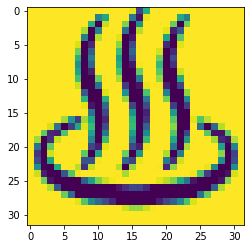

In [509]:
plt.imshow(all_imgs[0])
plt.show()

In [510]:
#train_set['seq_ind'][0]
train_set['seq_ind'].shape + all_imgs.shape[1:]

train_set['seq_ind'].shape[0]

18810

In [511]:
x_train = np.empty(shape=train_set['seq_ind'].shape + all_imgs.shape[1:],
                   dtype=float)

for i in range(train_set['seq_ind'].shape[0]):
    x_train[i][0] = all_imgs[train_set['seq_ind'][i][0]]
    x_train[i][1] = all_imgs[train_set['seq_ind'][i][1]]

In [512]:
x_test = np.empty(shape=test_set['seq_ind'].shape + all_imgs.shape[1:],
                   dtype=float)

for i in range(test_set['seq_ind'].shape[0]):
    x_test[i][0] = all_imgs[test_set['seq_ind'][i][0]]
    x_test[i][1] = all_imgs[test_set['seq_ind'][i][1]]
    
x_test.shape

(990, 2, 32, 32)

In [513]:
x_train.shape

(18810, 2, 32, 32)

differnt?  False


<Figure size 432x288 with 0 Axes>

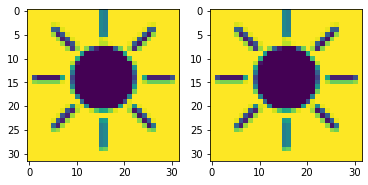

In [514]:
testi = 0
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(x_train[testi][0])
axarr[1].imshow(x_train[testi][1])

print("differnt? ", bool(train_set['y'][testi]))

differnt?  False


<Figure size 432x288 with 0 Axes>

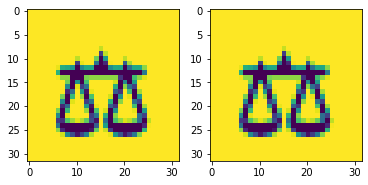

In [515]:
testi = 5
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(x_train[testi][0])
axarr[1].imshow(x_train[testi][1])

print("differnt? ", bool(train_set['y'][testi]))

# Model

In [438]:
x = keras.layers.Input(x_train.shape[1:])
#y =x
y = ESBN(output_dim=2)(x)

#y = keras.layers.Flatten()(y)
#y = tf.keras.layers.Softmax()(y)
y = keras.layers.Dense(1, activation=keras.activations.sigmoid)(y)
y = keras.layers.Flatten()(y)
#y = keras.layers.Dense(1, activation=keras.activations.softmax)(y)
#Class tokens

model = keras.Model(x, y)

images shape:  (None, 2, 32, 32)
b shape  2
in loop single shape: (None, 32, 32)
z :  (None, 64)
kx  Tensor("esbn_56/zeros_4:0", shape=(None, 1, 65), dtype=float32)
hx :  (None, 1, 512)
cx :  Tensor("esbn_56/zeros_3:0", shape=(None, 1, 512), dtype=float32)


ValueError: Exception encountered when calling layer "esbn_56" (type ESBN).

in user code:

    File "/tmp/ipykernel_836/882238296.py", line 76, in body  *
        hx, cx = self.rnn(kx, (hx, cx)) #return state?
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "lstm_cell_53" (type LSTMCell).
    
    Dimension size must be evenly divisible by 4 but is 1
    	Number of ways to split should evenly divide the split dimension for '{{node esbn_56/while/lstm_cell_53/split}} = Split[T=DT_FLOAT, num_split=4](esbn_56/while/lstm_cell_53/split/split_dim, esbn_56/while/lstm_cell_53/BiasAdd)' with input shapes: [], [?,1,2048] and with computed input tensors: input[0] = <1>.
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 65), dtype=float32)
      • states=('tf.Tensor(shape=(None, 1, 512), dtype=float32)', 'tf.Tensor(shape=(None, 1, 512), dtype=float32)')
      • training=None


Call arguments received:
  • images=tf.Tensor(shape=(None, 2, 32, 32), dtype=float32)

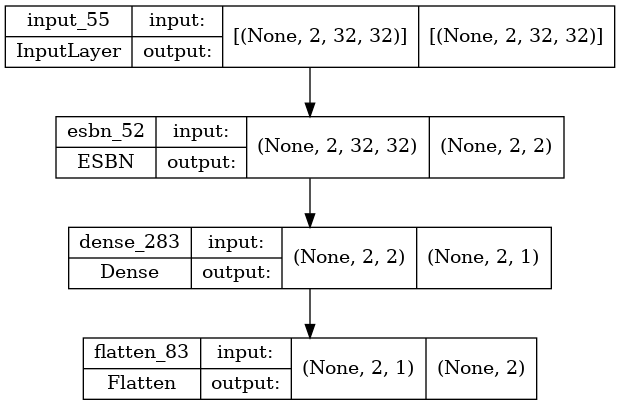

In [425]:
keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [426]:
#lr = 0.01
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(lr),
              metrics=keras.metrics.SparseCategoricalAccuracy())

In [427]:
testi = 0
prediction = model.predict(x_train[testi:testi+4])
prediction

images shape:  (None, 2, 32, 32)
b shape  2
in loop single shape: (None, 32, 32)
z :  (2, 512)
hx :  (2, 512)


array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]], dtype=float32)

In [428]:
train_set['y'][testi:testi+4]

array([1, 1, 1, 0])

In [429]:
keras.metrics.BinaryAccuracy()(train_set['y'][testi:testi+4],prediction)

InvalidArgumentError: Incompatible shapes: [4] vs. [4,2] [Op:Equal]

In [430]:
epochs = 20
history = model.fit(x_train, train_set['y'],
                    batch_size=train_batch_size,
                    epochs=epochs,
                    validation_split=0.2,#1-train_proportion,
                    verbose=1)

Epoch 1/20
images shape:  (None, 2, 32, 32)
b shape  2
in loop single shape: (None, 32, 32)
z :  (2, 512)
hx :  (2, 512)
images shape:  (None, 2, 32, 32)
b shape  2
in loop single shape: (None, 32, 32)
z :  (2, 512)
hx :  (2, 512)
471/471 [==============================] - ETA: 0s - loss: 0.6931 - sparse_categorical_accuracy: 0.5030images shape:  (None, 2, 32, 32)
b shape  2
in loop single shape: (None, 32, 32)
z :  (2, 512)
hx :  (2, 512)
471/471 [==============================] - 3s 4ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5030 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.4880
Epoch 2/20
471/471 [==============================] - 1s 2ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5030 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.4880
Epoch 3/20
471/471 [==============================] - 1s 2ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5030 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.4880
Epoch 4/20
471/471 [=======

In [389]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

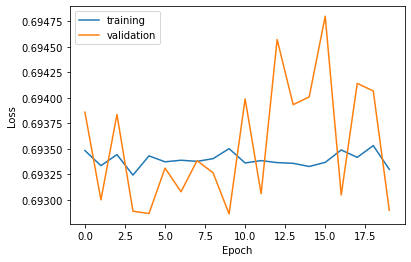

In [390]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

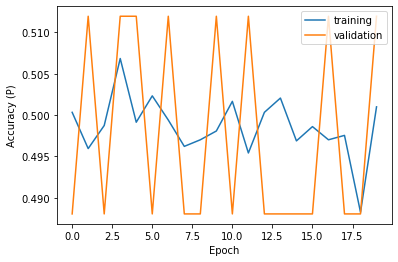

In [391]:
plt.plot(history.history['binary_accuracy'], label='training')
plt.plot(history.history['val_binary_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (P)')
plt.show()

# Test